# Plan of Action

In [1]:
import matplotlib.pyplot as plt
import os
import importlib
import pandas

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
import common_utils
importlib.reload(common_utils)
from common_utils import *

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

np.random.seed(69)
tf.random.set_seed(69)

## Import Dataset

In [2]:
# normal data
image_paths_csv = pd.read_csv("./processed_data/image_paths_7_classes.csv")
#aug data
image_paths_csv_aug = pd.read_csv("./processed_data/image_paths_7_classes_aug.csv")



## Organize Dataset

In [3]:

data= load_tensors_from_paths_csv(paths_csv=image_paths_csv)
aug_data=load_tensors_from_paths_csv(paths_csv=image_paths_csv_aug)


# Image Greyscale Function

# CNN Architecture

Batch 1: config_1
A bunch of options based on the suggestions in the assignment.
Best models: \
    {"name": "B2_deep", "conv_filters": [32, 64, 128, 256, 512]}, \ 
    {"name": "K1_k7_deep", "kernel_size": 7, "conv_filters": [64, 128, 256]} \
    {"name": "E4_epochs_300", "epochs": 300}, \
    {"name": "J2_dense_256_128", "dense_units": [256, 128]}, acc: 0.4096 \
    {"name": "A3_relu_k5", "activation": "relu", "kernel_size": 5}, \
Worst model: \
    {"name": "I1_deep_selu", "activation": "selu", "conv_filters": [64, 128, 256, 512]}, \
    {"name": "I2_shallow_tanh", "activation": "tanh", "conv_filters": [16, 32]}, \
    {"name": "A4_selu_k7", "activation": "selu", "kernel_size": 7}, \
    {"name": "A2_tanh_k3", "activation": "tanh", "kernel_size": 3}, \
    {"name": "B1_shallow", "conv_filters": [32, 64]}, \
    
Batch 2: config_2 \
Tried fixing the bad, improving the best \
Best models: \
{"name": "A3B_relu_k5_improved", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256], "dropout_rate": 0.5}, \
{"name": "B2B_deep_bn", "conv_filters": [32, 64, 128, 256, 512], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True}, \
{"name": "A4B_relu_k7", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128]},

Bad models: \
{"name": "I2B_mid_relu", "activation": "relu", "conv_filters": [32, 64, 128]}, \
{"name": "J2B_dense_256_128", "dense_units": [256, 128], "activation": "relu", "dropout_rate": 0.5, 
 "batch_norm_dense": True}, acc: 0.3898 \
{"name": "E4B_epochs_300", "epochs": 300, "dropout_rate": 0.5, "lr_schedule": "reduce_on_plateau"}, didn't improve much  \



In [4]:
# first batch, a bunch of random-ish models
config_1 = [
    {"name": "baseline"},
    
    {"name": "A1_relu_k3", "activation": "relu", "kernel_size": 3},
    {"name": "A3_relu_k5", "activation": "relu", "kernel_size": 5},
    
    {"name": "B2_deep", "conv_filters": [32, 64, 128, 256, 512]},
    
    {"name": "J1_dense_512", "dense_units": [512]},
    {"name": "J2_dense_256_128", "dense_units": [256, 128]},
    
    {"name": "E1_dense1", "dense_units": [128]},
    {"name": "E2_dense3", "dense_units": [256, 128, 64]},
    
      # Grayscale (1-channel) input
    {"name": "F1_gray", "channels": 1},
    {"name": "F2_gray_k5", "channels": 1, "kernel_size": 5},
    {"name": "F3_gray_deep", "channels": 1, "conv_filters": [32, 64, 128, 256]},
    {"name": "F4_gray_dense2", "channels": 1, "dense_units": [256, 128]},

    
    {"name": "H1_dropout_0.3", "dropout_rate": 0.3},
    {"name": "H2_dropout_0.7", "dropout_rate": 0.7},
    
        # Batch size variations
    {"name": "B3_batch_128", "batch_size": 128},
    {"name": "B4_batch_64", "batch_size": 64},
    
        # Epoch variations
    {"name": "E1_epochs_60", "epochs": 60},
    {"name": "E2_epochs_180", "epochs": 180},
    {"name": "E3_epochs_240", "epochs": 240},
    {"name": "E4_epochs_300", "epochs": 300},

    {"name": "K1_k7_deep", "kernel_size": 7, "conv_filters": [64, 128, 256]}
    ]

# second batch, improve on best, fix worse
config_2 = [
    {"name": "baseline"},
    # Improved version of "B2_deep"
    {"name": "B2B_deep_bn", "conv_filters": [32, 64, 128, 256, 512], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True},
    # Improved version of "K1_k7_deep"
    {"name": "K1B_k7_deep_bn", "kernel_size": 7, "conv_filters": [64, 128, 256, 512], "activation": "relu", "dropout_rate": 0.4, "batch_norm": True},
    # Improved version of "E4_epochs_300"
    {"name": "E4B_epochs_300", "epochs": 300, "dropout_rate": 0.5, "lr_schedule": "reduce_on_plateau"},
    # Improved version of "J2_dense_256_128"
    {"name": "J2B_dense_256_128", "dense_units": [256, 128], "activation": "relu", "dropout_rate": 0.5, "batch_norm_dense": True},
    # Improved version of "A3_relu_k5"
    {"name": "A3B_relu_k5_improved", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256], "dropout_rate": 0.5},
    # Fix for "I1_deep_selu"
    {"name": "I1B_deep_relu_bn", "activation": "relu", "conv_filters": [64, 128, 256, 512], "dropout_rate": 0.4},


    # Fix for "I2_shallow_tanh"
    {"name": "I2B_mid_relu", "activation": "relu", "conv_filters": [32, 64, 128]},
    # Fix for "A4_selu_k7"
    {"name": "A4B_relu_k7", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128]},
    # Fix for "A2_tanh_k3"
    {"name": "A2B_relu_k3_deeper", "activation": "relu", "kernel_size": 3, "conv_filters": [32, 64, 128, 256]},
    # Fix for "B1_shallow"
    {"name": "B1B_deep_dense", "conv_filters": [32, 64, 128], "dense_units": [256, 128]}
]

# third batch, take the best from batch 2 and try on 7 classes instead of 13.
config_3 = [
    {"name": "baseline"},
    {"name": "A3B_relu_k5_improved_7_classes", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256], "dropout_rate": 0.5}, 
    {"name": "B2B_deep_bn_7_classes", "conv_filters": [32, 64, 128, 256, 512], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True}, 
    {"name": "A4B_relu_k7_7_classes", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128]},
]

# forth batch, will try the same 7 classes, but without normalising the images
# This just made it worse. I have also decided to drop the epochs to 60 since validation is not increasing after that
config_4 = [
    {"name": "baseline_7_classes_non_normalized"},
    {"name": "A3B_relu_k5_improved_7_classes_non_normalized", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256], "dropout_rate": 0.5, "normalize": False}, 
    {"name": "B2B_deep_bn_7_classes_non_normalized", "conv_filters": [32, 64, 128, 256, 512], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"normalize": False}, 
    {"name": "A4B_relu_k7_7_classes_non_normalized", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128],"normalize": False},
]

# fifth batch, going back to normalized photos, but will test the same models with matched dense layers and more of them  version of the images
# Similar results, not significantlly better 
config_5 = [
    {"name": "baseline_7_classes_dense"},
    {"name": "A3B_relu_k5_improved_7_classes_dense", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128], "dropout_rate": 0.5}, 
    {"name": "B2B_deep_bn_7_classes_dense", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True}, 
    {"name": "A4B_relu_k7_7_classes_dense", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128],"dense_units":[128,64]},
]

# sixth batch, using previous. models but on grayscale image
# yet again, not much change
config_6 = [
    {"name": "baseline_7_classes_dense"},
    {"name": "A3B_relu_k5_improved_7_classes_dense", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128], "dropout_rate": 0.5,"channels":1}, 
    {"name": "B2B_deep_bn_7_classes_dense", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"channels":1}, 
    {"name": "A4B_relu_k7_7_classes_dense", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128],"dense_units":[128,64],"channels":1},
]

# for batch 7, I will do the training using the previous model on grayscale and 3 channel images
# I Messed up and overwrote the grayscale models by the color models. However, the results were extraordinary.
# 🔍 B2B_deep_bn_7_classes_dense — Evaluation on Test Set:loss: 1.0621 accuracy: 0.7415
# A3B_relu_k5_improved_7_classes_dense — Evaluation on Test Set:loss: 1.0519 accuracy: 0.7343

config_7 = [
    # 3 channels
    {"name": "baseline_7_classes_aug","channels":3,"aug_data":True},
    {"name": "A3B_relu_k5_improved_7_classes_dense", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128], "dropout_rate": 0.5,"channels":3,"aug_data":True}, 
    {"name": "B2B_deep_bn_7_classes_dense", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"channels":3,"aug_data":True}, 
    {"name": "A4B_relu_k7_7_classes_dense", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128],"dense_units":[128,64],"channels":3,"aug_data":True},
]

# Batch 8, I'll do the same test but with gray scale to check for differences.
# didn't go better, had sligly less accurate models. Gray scale is not good. 
# Also, due to the size of the augmented data, training takes way way way longer.
# So I have decided to only continue with the top 2 models so far, that being the B2B_deep_bn_7_classes_dense and A3B_relu_k5_improved_7_classes_dense

config_8 = [
    # grayscale channels
    {"name": "baseline_7_classes_aug_gray","channels":1,"aug_data":True},
    {"name": "A3B_relu_k5_improved_7_classes_dense_aug_gray", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128], "dropout_rate": 0.5,"channels":1,"aug_data":True}, 
    {"name": "B2B_deep_bn_7_classes_dense_aug_gray", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"channels":1,"aug_data":True}, 
    {"name": "A4B_relu_k7_7_classes_dense_aug_gray", "activation": "relu", "kernel_size": 7, "conv_filters": [32, 64, 128],"dense_units":[128,64],"channels":1,"aug_data":True},
]
# batch 9, I used the functional model api to make it to allow skip connections,
# this should, in theory, make the large CNN perform better.
# updated batch_size to 512 for faster training
# FINALLY, I broke through the ice I had set in my head as the minimum, that being 80%+ accuracy on the test data set.
# That is also where I am doing to stop. 
# The grand winners for the classification are:
#  B2B_deep_bn_7_classes_dense_aug_batch_norm_skip and  A3B_relu_k5_improved_7_classes_dense_aug_batch_norm_skip
config_9=[
    #skip true , batch norm true, batch norm dense true
    {"name": "A3B_relu_k5_improved_7_classes_dense_aug_batch_norm_skip", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128],"batch_norm": True,"batch_norm_dense": True, "dropout_rate": 0.5,"aug_data":True,"use_skip": True},
    
    {"name": "B2B_deep_bn_7_classes_dense_aug_batch_norm_skip", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,"aug_data":True,"use_skip":True},
    
    # skip true, batch norm false, batch norm dense false
    {"name": "A3B_relu_k5_improved_7_classes_dense_aug_skip", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128], "dropout_rate": 0.5,"aug_data":True,"use_skip": True},
    
    {"name": "B2B_deep_bn_7_classes_dense_aug_skip", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5,"aug_data":True,"use_skip":True},
]


# Regression time

# batch one 1, I'll just train the best model I found so far and go from there
# so bad, so many mistakes i made, so many things i forgot. It just failed miserably, MSE is massive.
# Will train all the previous models and see where to go from there
# Who would've thought, most are not just awful, but outright sad. Only one got a decent results and that is

config_10=[
    {"name": "baseline"},
    {"name": "baseline_non_normalized", "normalize": False},
    {"name": "baseline_dense"},
    {"name": "baseline_aug", "aug_data": True},
    {"name": "baseline_aug_gray", "channels": 1, "aug_data": True},

    {"name": "A1_relu_k3"},
    {"name": "A3_relu_k5", "kernel_size": 5},

    {"name": "B2_deep", "conv_filters": [32, 64, 128, 256, 512]},

    {"name": "J1_dense_512", "dense_units": [512]},
    {"name": "J2_dense_256_128", "dense_units": [256, 128]},
    {"name": "E1_dense1"},
    {"name": "E2_dense3", "dense_units": [256, 128, 64]},

    {"name": "F1_gray", "channels": 1},
    {"name": "F2_gray_k5", "channels": 1, "kernel_size": 5},
    {"name": "F3_gray_deep", "channels": 1, "conv_filters": [32, 64, 128, 256]},
    {"name": "F4_gray_dense2", "channels": 1, "dense_units": [256, 128]},

    {"name": "H1_dropout_0.3", "dropout_rate": 0.3},
    {"name": "H2_dropout_0.7", "dropout_rate": 0.7},

    {"name": "B3_batch_128", "batch_size": 128},
    {"name": "B4_batch_64", "batch_size": 64},

    {"name": "E1_epochs_60", "epochs": 60},
    {"name": "E2_epochs_180", "epochs": 180},
    {"name": "E3_epochs_240", "epochs": 240},
    {"name": "E4_epochs_300", "epochs": 300},

    {"name": "K1_k7_deep", "kernel_size": 7, "conv_filters": [64, 128, 256]},

    {"name": "B2B_deep_bn", "conv_filters": [32, 64, 128, 256, 512], "batch_norm": True},
    {"name": "K1B_k7_deep_bn", "kernel_size": 7, "conv_filters": [64, 128, 256, 512],
     "dropout_rate": 0.4, "batch_norm": True},
    {"name": "E4B_epochs_300", "epochs": 300, "lr_schedule": "reduce_on_plateau"},
    {"name": "J2B_dense_256_128", "dense_units": [256, 128], "batch_norm_dense": True},
    {"name": "A3B_relu_k5_improved", "kernel_size": 5, "conv_filters": [32, 64, 128, 256]},
    {"name": "I1B_deep_relu_bn", "conv_filters": [64, 128, 256, 512], "dropout_rate": 0.4},
    {"name": "I2B_mid_relu"},
    {"name": "A4B_relu_k7", "kernel_size": 7},
    {"name": "A2B_relu_k3_deeper", "conv_filters": [32, 64, 128, 256]},
    {"name": "B1B_deep_dense", "dense_units": [256, 128]},

    {"name": "A3B_relu_k5_improved_reg", "kernel_size": 5, "conv_filters": [32, 64, 128, 256]},
    {"name": "B2B_deep_bn_reg", "conv_filters": [32, 64, 128, 256, 512], "batch_norm": True},
    {"name": "A4B_relu_k7_reg", "kernel_size": 7},
    {"name": "A3B_relu_k5_improved_reg_non_norm", "kernel_size": 5, "conv_filters": [32, 64, 128, 256],
     "normalize": False},
    {"name": "B2B_deep_bn_reg_non_norm", "conv_filters": [32, 64, 128, 256, 512],
     "batch_norm": True, "normalize": False},
    {"name": "A4B_relu_k7_reg_non_norm", "kernel_size": 7, "normalize": False},
    {"name": "A3B_relu_k5_improved_reg_dense", "kernel_size": 5, "conv_filters": [32, 64, 128, 256],
     "dense_units": [256, 128]},
    {"name": "B2B_deep_bn_reg_dense", "conv_filters": [32, 64, 128, 256, 512],
     "dense_units": [512, 256, 128], "batch_norm": True},
    {"name": "A4B_relu_k7_reg_dense", "kernel_size": 7, "dense_units": [128, 64]},
    {"name": "A3B_relu_k5_improved_reg_dense_gray", "kernel_size": 5, "conv_filters": [32, 64, 128, 256],
     "dense_units": [256, 128], "channels": 1},
    {"name": "B2B_deep_bn_reg_dense_gray", "conv_filters": [32, 64, 128, 256, 512],
     "dense_units": [512, 256, 128], "batch_norm": True, "channels": 1},
    {"name": "A4B_relu_k7_reg_dense_gray", "kernel_size": 7, "channels": 1},
    {"name": "A3B_relu_k5_improved_reg_aug", "kernel_size": 5, "conv_filters": [32, 64, 128, 256],
     "dense_units": [256, 128], "aug_data": True},
    {"name": "B2B_deep_bn_reg_aug", "conv_filters": [32, 64, 128, 256, 512],
     "dense_units": [512, 256, 128], "batch_norm": True, "aug_data": True},
    {"name": "A4B_relu_k7_reg_aug", "kernel_size": 7, "aug_data": True},
    {"name": "A3B_relu_k5_improved_reg_aug_gray", "kernel_size": 5, "conv_filters": [32, 64, 128, 256],
     "dense_units": [256, 128], "channels": 1, "aug_data": True},
    {"name": "B2B_deep_bn_reg_aug_gray", "conv_filters": [32, 64, 128, 256, 512],
     "dense_units": [512, 256, 128], "batch_norm": True, "channels": 1, "aug_data": True},
    {"name": "A4B_relu_k7_reg_aug_gray", "kernel_size": 7, "channels": 1, "aug_data": True},
    {"name": "A3B_relu_k5_improved_reg_aug_bn_skip", "kernel_size": 5, "conv_filters": [32, 64, 128, 256],
     "dense_units": [256, 128], "batch_norm": True, "batch_norm_dense": True,
     "aug_data": True, "use_skip": True},
    {"name": "B2B_deep_bn_reg_aug_bn_skip", "conv_filters": [32, 64, 128, 256, 512],
     "dense_units": [512, 256, 128], "batch_norm": True, "batch_norm_dense": True,
     "aug_data": True, "use_skip": True},
    {"name": "A3B_relu_k5_improved_reg_aug_skip", "kernel_size": 5, "conv_filters": [32, 64, 128, 256],
     "dense_units": [256, 128], "aug_data": True, "use_skip": True},
    {"name": "B2B_deep_bn_reg_aug_skip", "conv_filters": [32, 64, 128, 256, 512],
     "dense_units": [512, 256, 128], "aug_data": True, "use_skip": True},
]

# I have no idea why but B2B_deep_bn_reg_dense_gray got an outlier of a result, 51 MSE. I will check this one in depth with more epochs and see what's happening
# Ok so, i found out somehting interesting, my validation loss goes very high in the first 30 - ish epochs and then 
# comes down to a decent value. The early stopping was causing the models to be pretty much random,
# 
config_11 = [
    {"name": "B2B_deep_bn_reg_dense_gray", "conv_filters": [32, 64, 128, 256, 512],"dense_units": [512, 256, 128], "batch_norm": True, "channels": 1},
    {"name": "B2B_deep_bn","conv_filters": [32, 64, 128, 256, 512],"batch_norm": True,}

]
# Trained the best again with delayed early stopping and 120 epochs.
config_12 = [
    {"name": "B2B_deep_bn_reg_dense_gray", "conv_filters": [32, 64, 128, 256, 512],"dense_units": [512, 256, 128], "batch_norm": True, "channels": 1},
    {"name": "B2B_deep_bn_reg", "conv_filters": [32, 64, 128, 256, 512], "batch_norm": True},
    
    {"name": "A3B_relu_k5_reg_dense_aug_bn_skip", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128],"batch_norm": True,"batch_norm_dense": True, "dropout_rate": 0.5,"aug_data":True,"use_skip": True},
    
    {"name": "B2B_deep_bn_reg_dense_aug_bn_skip", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,"aug_data":True,"use_skip":True},
    
    {"name": "A3B_relu_k5_reg_dense_aug_skip", "activation": "relu","kernel_size": 5, "conv_filters": [32, 64, 128, 256],"dense_units":[256,128], "dropout_rate": 0.5,"aug_data":True,"use_skip": True},
    
    {"name": "B2B_deep_reg_dense_aug_skip", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5,"aug_data":True,"use_skip":True},
]

# not half bad. some decent results, I would say, swtiched to mae for validation because it makes a bit more sense to me.
# How far off are we from the real age? That's pretty much it. And I got a 7.17 and a 7.99. Not good, but not bad
# definitely way better than some other ones.
config_13 = [
{"name": "B2B_deep_bn_reg_aug_bn_skip", "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "batch_norm_dense": True, "aug_data": True, "use_skip": True},
{"name": "B2B_deep_bn_reg_aug", "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "aug_data": True},
{"name": "B2B_deep_bn_reg_aug_skip", "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "aug_data": True, "use_skip": True},
{"name": "A3B_relu_k5_improved_reg_aug", "kernel_size": 5, "conv_filters": [32,64,128,256], "dense_units": [256,128], "aug_data": True},
{"name": "B2B_deep_bn_reg_aug_gray", "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "channels": 1, "aug_data": True},

# added l2 reglr
{"name": "B2B_deep_bn_reg_dense_gray", "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "channels": 1,"l2_reg":1e-4},
{"name": "B2B_deep_bn_reg", "conv_filters": [32,64,128,256,512], "batch_norm": True,"l2_reg":1e-4},
{"name": "B2B_deep_bn", "conv_filters": [32,64,128,256,512], "batch_norm": True, "l2_reg":1e-4},


]

# I'll take the top three from the last training and just train them for longer

B2B_deep_bn_reg_aug	103.85	7.17	
B2B_deep_bn_reg_aug_gray	136.48	7.99
B2B_deep_bn_reg_dense_gray	232.58	10.67	



In [9]:
config_count = 14

configs = [
{"name": "B2B_deep_bn_reg_aug","epochs":500, "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "aug_data": True},
{"name": "B2B_deep_bn_reg_aug_gray","epochs":500, "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "channels": 1, "aug_data": True},
{"name": "B2B_deep_bn_reg_dense_gray","epochs":500, "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "channels": 1,"l2_reg":1e-4},

# for funsies:
{"name": "B2B_deep_bn_reg_aug","epochs":500,"activation":"linear", "conv_filters": [32,64,128,256,512], "dense_units": [512,256,128], "batch_norm": True, "aug_data": True}
]

# "l2_reg":1e-4

default_args = {
    "batch_size": 512,
    "epochs": 120,
    "channels": 3,
    "dropout_rate": 0.5,
    "task": "regression",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}


ratio=1
# Build all models and store in DataFrame
model_list = []
for cfg in configs:
    cfg_full = {**default_args, **cfg}
    cfg_full["loss"]='categorical_crossentropy' if cfg_full["task"] =="classification" else "mse"
    cfg_full["metrics"]=['accuracy'] if cfg_full["task"] =="classification" else ["mse","mae"]
    
    
    dict_for_data= aug_data if cfg_full["aug_data"] else data
    label_kind = "labels" if cfg_full["task"] =="classification" else "labels_regr"
    train_dataset = load_images_from_paths(dict_for_data["train"]["filenames"], dict_for_data["train"][label_kind], 
                                           channels=cfg_full["channels"],
                                           ratio=ratio,
                                           batch_size=cfg_full['batch_size'],
                                           class_count=cfg_full['num_classes'],
                                           normalize=cfg_full['normalize'],
                                           task=cfg_full['task'])
    
    val_dataset = load_images_from_paths(data["val"]["filenames"], data["val"][label_kind],
                                         channels=cfg_full["channels"],
                                         ratio=ratio,
                                         batch_size=cfg_full['batch_size'],
                                         class_count=cfg_full['num_classes'],
                                         normalize=cfg_full['normalize'],
                                         task=cfg_full['task'])

    test_dataset = load_images_from_paths(data["test"]["filenames"], data["test"][label_kind],
                                         channels=cfg_full["channels"],
                                         ratio=ratio,
                                         batch_size=cfg_full['batch_size'],
                                         class_count=cfg_full['num_classes'],
                                         normalize=cfg_full['normalize'],
                                         task=cfg_full['task'])
    
    # if skip, make it functional 
    if cfg_full["use_skip"]:
        model = build_cnn_model(
            channels=cfg_full["channels"],
            dropout_rate=cfg_full["dropout_rate"],
            task=cfg_full["task"],
            num_classes=cfg_full["num_classes"],
            conv_filters=cfg_full["conv_filters"],
            kernel_size=cfg_full["kernel_size"],
            activation=cfg_full["activation"],
            dense_units=cfg_full["dense_units"],
            output_activation=cfg_full["output_activation"],
            batch_norm=cfg_full["batch_norm"],
            batch_norm_dense=cfg_full["batch_norm_dense"],
        )
    else:
        # make it sequential
        model = build_sequential_cnn_model(
            channels=cfg_full["channels"],
            dropout_rate=cfg_full["dropout_rate"],
            task=cfg_full["task"],
            num_classes=cfg_full["num_classes"],
            conv_filters=cfg_full["conv_filters"],
            kernel_size=cfg_full["kernel_size"],
            activation=cfg_full["activation"],
            dense_units=cfg_full["dense_units"],
            output_activation=cfg_full["output_activation"],
            batch_norm=cfg_full["batch_norm"],
            batch_norm_dense=cfg_full["batch_norm_dense"],
            
        )
    
    optimizer = Adam(learning_rate=0.00001)
    model.compile(loss=cfg_full["loss"], optimizer=optimizer, metrics=cfg_full["metrics"])
    cfg_full["model"] = model
    cfg_full["train_data"]=train_dataset
    cfg_full["val_data"]=val_dataset
    cfg_full["test_data"]=test_dataset
    
    model_list.append(cfg_full)




In [6]:
for config in model_list:
    print(f"\nModel: {config['name']}")
    
    # Create iterators for the datasets
    train_iter = iter(config["train_data"])
    val_iter = iter(config["val_data"])
    test_iter = iter(config["test_data"])
    
    # Print header
    header = "{:<5}{:<25}{:<25}{:<25}".format("Idx", "Train Label", "Val Label", "Test Label")
    print(header)
    print("-" * len(header))
    
    # Iterate for the first 10 batches
    for i in range(2):
        train_sample = next(train_iter, None)
        val_sample = next(val_iter, None)
        test_sample = next(test_iter, None)
        
        # Extract labels; assume each sample is (data, label)
        train_label = train_sample[1] if train_sample is not None else "None"
        val_label = val_sample[1] if val_sample is not None else "None"
        test_label = test_sample[1] if test_sample is not None else "None"
        
        # Convert tensors to lists for readable output (if needed)
        if hasattr(train_label, "numpy"):
            train_label = train_label.numpy().tolist()
        if hasattr(val_label, "numpy"):
            val_label = val_label.numpy().tolist()
        if hasattr(test_label, "numpy"):
            test_label = test_label.numpy().tolist()
        
        # Print the formatted row
        row = "{:<5}{:<25}{:<25}{:<25}".format(i, str(train_label), str(val_label), str(test_label))
        print(row)
    
    print("-" * len(header))



Model: B2B_deep_bn_reg_aug_bn_skip
Idx  Train Label              Val Label                Test Label               
--------------------------------------------------------------------------------
0    [28.0, 60.0, 37.0, 4.0, 49.0, 71.0, 89.0, 29.0, 85.0, 11.0, 6.0, 2.0, 85.0, 15.0, 58.0, 53.0, 8.0, 56.0, 45.0, 86.0, 75.0, 51.0, 35.0, 31.0, 8.0, 56.0, 3.0, 10.0, 22.0, 8.0, 56.0, 25.0, 3.0, 55.0, 23.0, 34.0, 3.0, 60.0, 1.0, 63.0, 17.0, 72.0, 49.0, 2.0, 4.0, 92.0, 18.0, 18.0, 19.0, 76.0, 7.0, 82.0, 9.0, 1.0, 3.0, 52.0, 80.0, 68.0, 50.0, 31.0, 54.0, 44.0, 35.0, 65.0, 3.0, 16.0, 1.0, 31.0, 23.0, 30.0, 26.0, 17.0, 8.0, 16.0, 32.0, 4.0, 20.0, 63.0, 24.0, 2.0, 28.0, 20.0, 10.0, 49.0, 28.0, 29.0, 2.0, 1.0, 10.0, 8.0, 3.0, 33.0, 79.0, 25.0, 82.0, 88.0, 4.0, 54.0, 67.0, 59.0, 1.0, 16.0, 2.0, 74.0, 8.0, 7.0, 28.0, 29.0, 77.0, 39.0, 4.0, 28.0, 9.0, 29.0, 8.0, 35.0, 32.0, 54.0, 6.0, 12.0, 52.0, 85.0, 58.0, 18.0, 85.0, 75.0, 36.0, 41.0, 29.0, 52.0, 2.0, 2.0, 15.0, 3.0, 30.0, 63.0, 75.0, 1.0, 10.0, 

In [7]:
model_list

[{'batch_size': 512,
  'epochs': 120,
  'channels': 3,
  'dropout_rate': 0.5,
  'task': 'regression',
  'num_classes': 7,
  'conv_filters': [32, 64, 128, 256, 512],
  'kernel_size': 3,
  'activation': 'relu',
  'dense_units': [512, 256, 128],
  'output_activation': 'softmax',
  'batch_norm': True,
  'batch_norm_dense': True,
  'normalize': True,
  'aug_data': True,
  'use_skip': True,
  'l2_reg': 0,
  'name': 'B2B_deep_bn_reg_aug_bn_skip',
  'loss': 'mse',
  'metrics': ['mse', 'mae'],
  'model': <keras.src.engine.functional.Functional at 0x779ef4e1e990>,
  'train_data': <_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
  'val_data': <_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
  'test_data': <_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32,

# Model Fitting

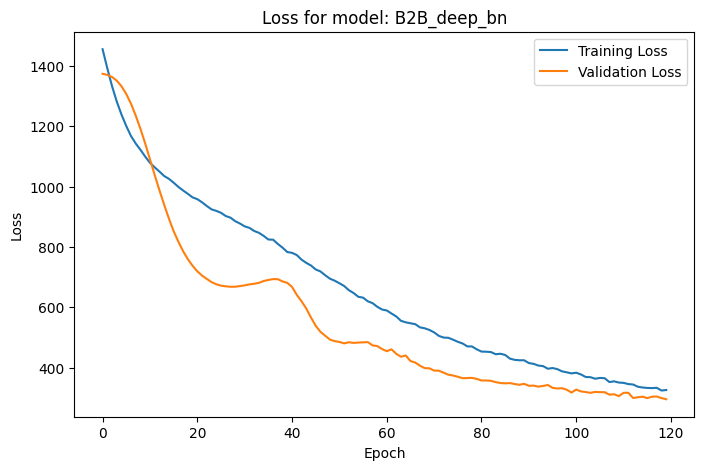

In [10]:
os.makedirs(f"regression_saved_models_config_{config_count}", exist_ok=True)
os.makedirs(f"classification_saved_models_config_{config_count}", exist_ok=True)


for entry in model_list:
    model_name = entry["name"]
    
    # Setup model checkpoint callback
    checkpoint_path = f"{entry['task']}_saved_models_config_{config_count}/{model_name}_best_model.keras"
    mse_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy' if entry["task"]=='classification' else 'val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )
    entry['best_model_path'] = checkpoint_path

    callbacks = [mse_checkpoint]

    if entry["task"]!='classification':
        mae_checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_mae',
            save_best_only=True,
            save_weights_only=False,
            verbose=0
        )
        callbacks.append(mae_checkpoint)

    # useless or I'm dumb and don't know how to use it properly
    if "lr_schedule" in entry:
        if entry["lr_schedule"] == "reduce_on_plateau":
            lr_callback = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                verbose=1
            )
            callbacks.append(lr_callback)

    early_stop_loss = DelayedEarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=0,
        restore_best_weights=False,
        delay=60  # begin checks after 60 epochs
    )
    
    if entry["task"]=='classification':
        early_stop_acc = EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            verbose=0,
            restore_best_weights=True
        )
        callbacks.append(early_stop_acc)

    callbacks.append(early_stop_loss)
    callbacks.append(LiveLossPlot(model_name=model_name))

    # Train model
    history = entry['model'].fit(
        entry['train_data'],
        validation_data=entry['val_data'],
        epochs=entry['epochs'],
        batch_size=entry['batch_size'],
        verbose=0,
        callbacks=callbacks
    )

    # Save training history in entry
    entry['history'] = history.history
    entry['best_model_path'] = checkpoint_path
    df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} for entry in model_list])
    df_model_summary.to_csv(f"regr_model_summary_config_{config_count}.csv", index=False)

    


    

# Checking Model Performance

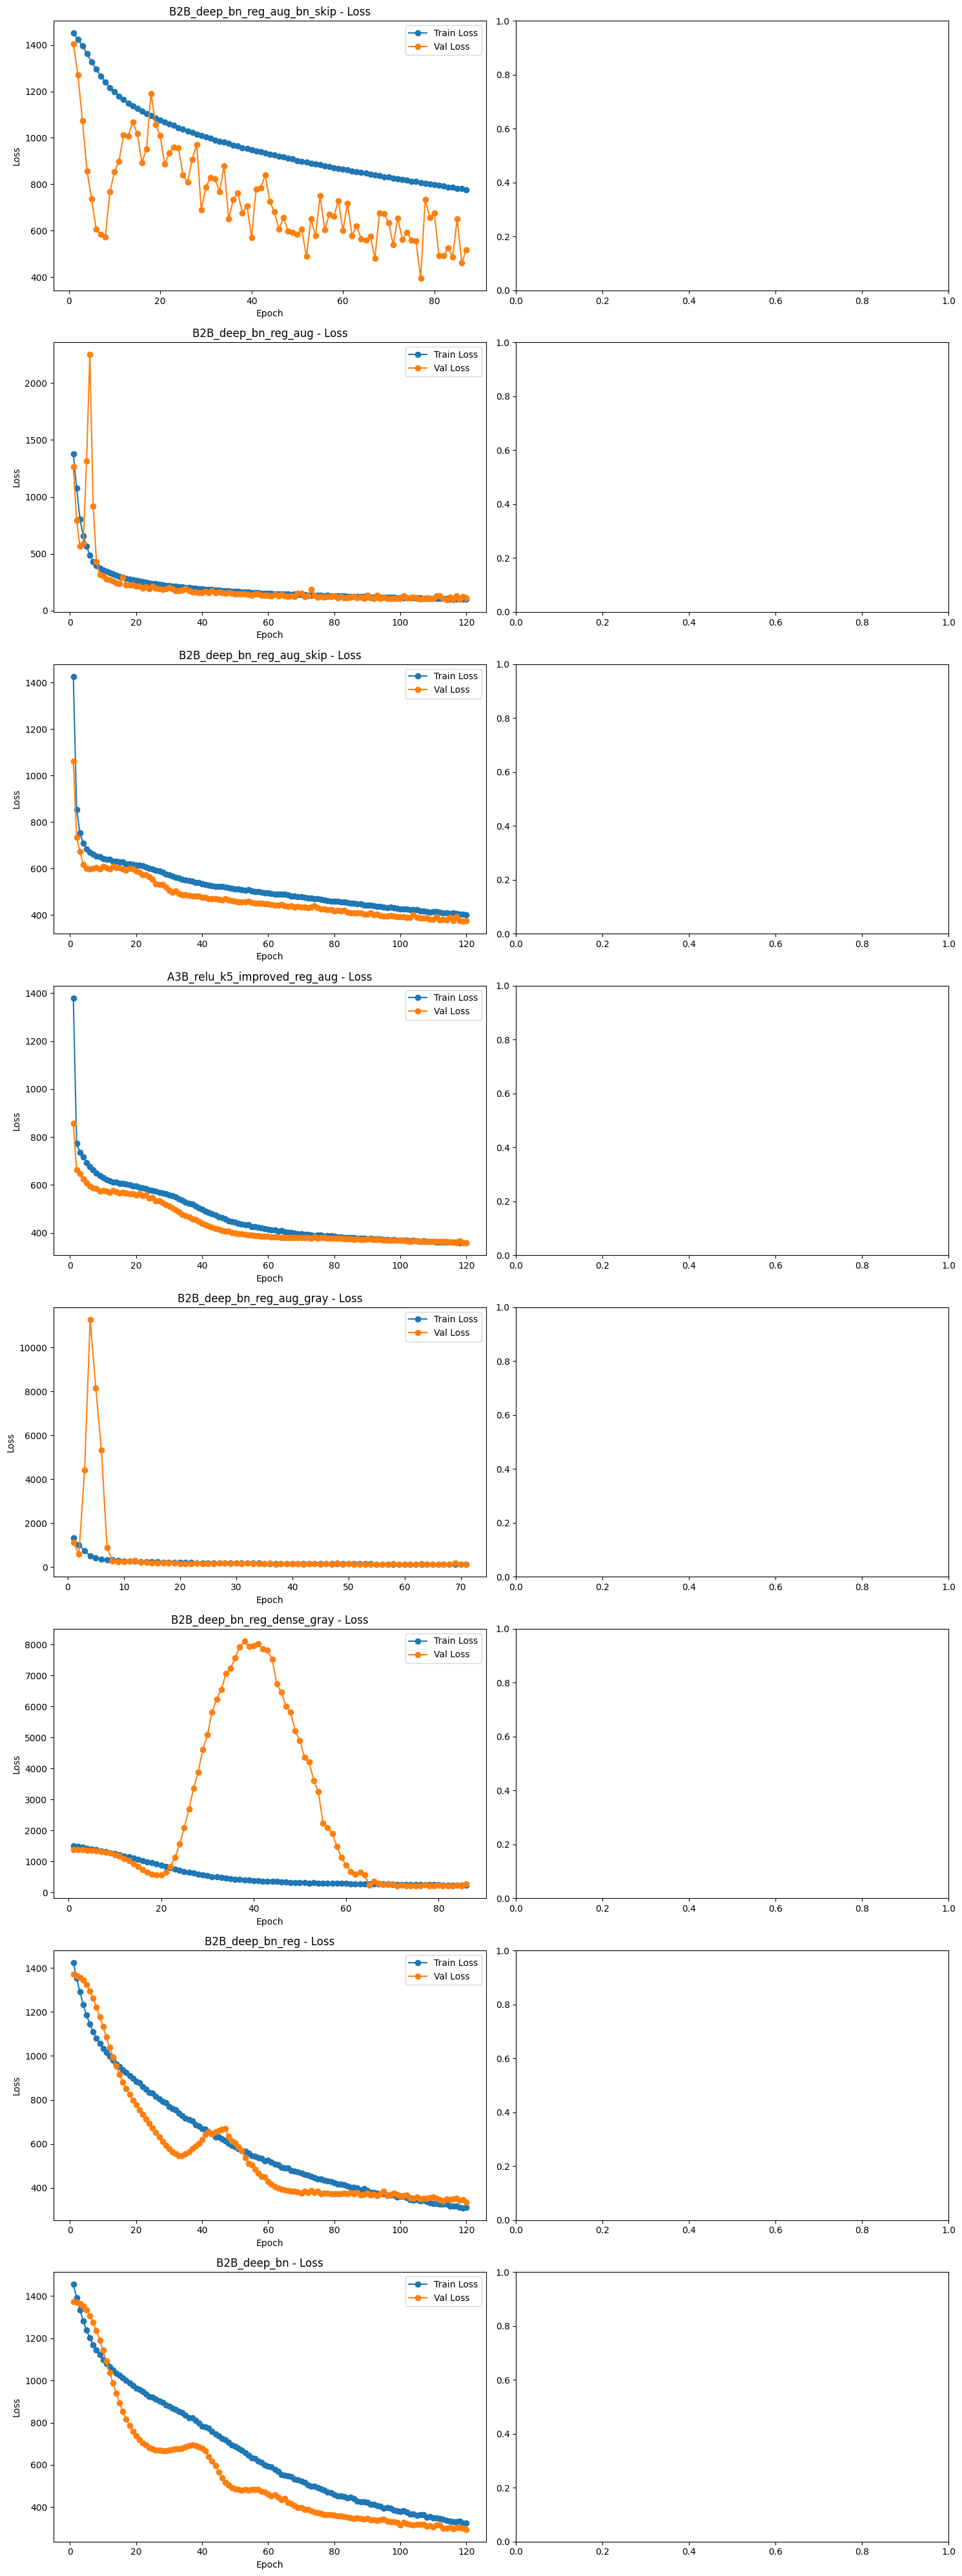

In [11]:

# Create subplots: one row per model, two columns (loss and accuracy)

fig, axes = plt.subplots(nrows=len(model_list), ncols=2, figsize=(15, 5 * len(model_list)))

# Ensure axes is always 2D
if len(model_list) == 1:
    axes = np.array([axes])

# Loop through each trained model entry
for i, entry in enumerate(model_list):
    try:
        model_name = entry["name"]
        history = entry["history"]
        epochs = list(range(1, len(history["loss"]) + 1))

        # Loss Plot
        ax_loss = axes[i, 0]
        ax_loss.plot(epochs, history["loss"], label='Train Loss', marker='o')
        ax_loss.plot(epochs, history["val_loss"], label='Val Loss', marker='o')
        ax_loss.set_title(f"{model_name} - Loss")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.legend()

        # Accuracy Plot
        ax_acc = axes[i, 1]
        ax_acc.plot(epochs, history["accuracy"], label='Train Accuracy', marker='o')
        ax_acc.plot(epochs, history["val_accuracy"], label='Val Accuracy', marker='o')
        ax_acc.set_title(f"{model_name} - Accuracy")
        ax_acc.set_xlabel("Epoch")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.legend()
    except Exception:
        continue

plt.tight_layout()
plt.show()

In [10]:
def get_preds_and_labels(model, dataset):
    y_pred = []
    y_true = []
    for batch in dataset:
        images, labels = batch
        probs = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(probs, axis=-1))
        y_true.extend(labels.numpy())
    return np.array(y_pred), np.array(y_true)


In [26]:
ratio=1
model_list_loaded=pd.read_csv(f"regr_model_summary_config_11.csv")
model_list = model_list_loaded.to_dict(orient='records')


for entry in model_list:
    dict_for_data= aug_data if entry["aug_data"] else data
    label_kind = "labels" if entry["task"] =="classification" else "labels_regr"


    test_dataset = load_images_from_paths(data["test"]["filenames"], data["test"][label_kind],
                                         channels=entry["channels"],
                                         ratio=ratio,
                                         batch_size=entry['batch_size'],
                                         class_count=entry['num_classes'],
                                         normalize=entry['normalize'],
                                         task=entry["task"])


    entry["test_data"]=test_dataset
    

In [1]:
%whos 

Interactive namespace is empty.


In [13]:


# Loop through each trained model entry
for i, entry in enumerate(model_list):
    
        model_name = entry["name"]
        best_model_path = f"{entry['task']}_saved_models_config_{config_count}/{model_name}_best_model.keras"
        
        test_dataset = entry['test_data']
        # Load the best saved model
        
        model = load_model(best_model_path)
        

        # Evaluate on test set
        model_score = model.evaluate(test_dataset, verbose=1)
        model_labels = model.metrics_names

        print(f"🔍 {model_name} — Evaluation on Test Set:")
        for label, score in zip(model_labels, model_score):
            print(f"   {label}: {round(score, 4)}")
        print("-" * 40)
        # y_pred = model.predict(test_dataset)
        # y_true = np.concatenate([y for x, y in test_dataset], axis=0)

        # Print predicted vs true values
        # print("📋 Predictions vs Ground Truth:")
        # for pred, true in zip(y_pred.flatten(), y_true.flatten()):
        #     print(f"   Predicted: {round(pred, 2)} — Actual: {int(true)}")

    

2/2 [==============================] - 2s 2s/step - loss: 420.6850 - mse: 420.6850 - mae: 18.1869
🔍 B2B_deep_bn_reg_aug_bn_skip — Evaluation on Test Set:
   loss: 420.685
   mse: 420.685
   mae: 18.1869
----------------------------------------
2/2 [==============================] - 2s 2s/step - loss: 103.8480 - mse: 103.8480 - mae: 7.1710
🔍 B2B_deep_bn_reg_aug — Evaluation on Test Set:
   loss: 103.848
   mse: 103.848
   mae: 7.171
----------------------------------------
2/2 [==============================] - 0s 79ms/step - loss: 387.9197 - mse: 387.9197 - mae: 14.8941
🔍 B2B_deep_bn_reg_aug_skip — Evaluation on Test Set:
   loss: 387.9197
   mse: 387.9197
   mae: 14.8941
----------------------------------------
2/2 [==============================] - 3s 2s/step - loss: 363.6287 - mse: 363.6287 - mae: 14.4099
🔍 A3B_relu_k5_improved_reg_aug — Evaluation on Test Set:
   loss: 363.6287
   mse: 363.6287
   mae: 14.4099
----------------------------------------
2/2 [==========================

### Plotting Confusion Matrix

In [13]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'./output/{export_as}.png', bbox_inches='tight')

In [14]:

# Define class labels
cm_plot_labels = ['1-2', '3-5', '6-8', '9-12', '13-17', '18-24', '25-34', 
                  '35-44', '45-54', '55-64', '65-74', '75-84', '85+']

# Loop through all models
for i, entry in enumerate(model_list):
    model_name = entry["name"]
    
    
    best_model_path = entry["best_model_path"]
    test_dataset = entry['test_data']

    print(f"🔍 Evaluating Confusion Matrix for: {model_name}")

    # Load the best saved model
    model = load_model(best_model_path)

    # Predict class probabilities
    model_pred_probs = model.predict(test_dataset)
    model_pred = model_pred_probs.argmax(axis=-1)
    y_pred, y_true = get_preds_and_labels(model, test_dataset)

    # y_true = dict_for_data["test"]["labels_regr"]

    # Compute confusion matrix
    if entry["task"]=="classification":
        conf_mat = confusion_matrix(y_true, model_pred)

        # Plot confusion matrix
        plt.figure(figsize=(16, 8))
        plot_confusion_matrix(
            conf_mat,
            cm_plot_labels,
            normalize=True,
            title=f"Confusion Matrix - {model_name}",
            export_as=None  # Change to f"{model_name}_confmat" to save
        )
        plt.show()

    print("Sample predictions vs actuals:")
    for pred, true in zip(y_pred[:10], y_true[:10]):
        print(f"Pred: {pred} — True: {true}")



🔍 Evaluating Confusion Matrix for: baseline
2/2 [==============================] - 0s 96ms/step
Sample predictions vs actuals:
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
🔍 Evaluating Confusion Matrix for: baseline_non_normalized
2/2 [==============================] - 0s 101ms/step
Sample predictions vs actuals:
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0. 0. 0. 0.]
Pred: 0 — True: [0. 0. 0. 0.

In [15]:
y_true


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)